In [ ]:
!pip install pmdarima yfinance tensorflow scikit-learn matplotlib

# Perform Forecast for all tickers

In [24]:
import yfinance as yf
import numpy as np
import pandas as pd
import scipy.optimize as sco
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load historical data for TSLA, BND, and SPY
symbols = ['TSLA', 'BND', 'SPY']
data = yf.download(symbols, start="2015-01-01", end="2025-01-31")['Close']

# Interpolate missing values if any
data = data.interpolate()

# Calculate daily returns
returns = data.pct_change().dropna()

# Generate synthetic future returns based on historical mean and std deviation
future_steps = 252  # Approximate trading days in a year
mean_returns = returns.mean()
std_dev = returns.std()

# Generate synthetic future returns
np.random.seed(0)  # For reproducibility
future_tsla_returns = np.random.normal(mean_returns['TSLA'], std_dev['TSLA'], future_steps)
future_bnd_returns = np.random.normal(mean_returns['BND'], std_dev['BND'], future_steps)
future_spy_returns = np.random.normal(mean_returns['SPY'], std_dev['SPY'], future_steps)

# Create a DataFrame for future returns
forecasted_returns = pd.DataFrame({
    'TSLA': future_tsla_returns,
    'BND': future_bnd_returns,
    'SPY': future_spy_returns
})


[*********************100%***********************]  3 of 3 completed


# Portfolio Risk & Return Analysis

In [25]:
# Compute the annualized return
annual_returns = forecasted_returns.mean() * 252
weights = np.array([0.3, 0.3, 0.3])  # Initial Portfolio weights for TSLA, BND, SPY
portfolio_returns = np.dot(annual_returns, weights)
portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
sharpe_ratio = portfolio_returns / portfolio_std_dev

print(f"Annual Portfolio Return: {portfolio_returns:.2f}")
print(f"Annual Portfolio Risk (Std Dev): {portfolio_std_dev:.2f}")
print(f"Portfolio Sharpe Ratio: {sharpe_ratio:.2f}")

Annual Portfolio Return: 0.13
Annual Portfolio Risk (Std Dev): 0.20
Portfolio Sharpe Ratio: 0.64


In [26]:
# Efficient Frontier Calculation
def portfolio_statistics(weights):
    weights = np.array(weights)
    port_return = np.dot(annual_returns, weights)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return np.array([port_return, port_volatility, port_return / port_volatility])

# Optimization to maximize the Sharpe Ratio
def min_func_sharpe(weights):
    return -portfolio_statistics(weights)[2]

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(symbols)))
result = sco.minimize(min_func_sharpe, len(symbols) * [1. / len(symbols)], bounds=bounds, constraints=constraints)
opt_weights = result.x
print(f"Optimized Portfolio Weights: {opt_weights}")

# Calculate and display the optimized portfolio statistics
optimized_portfolio = portfolio_statistics(opt_weights)
print(f"Optimized Annual Return: {optimized_portfolio[0]:.2f}")
print(f"Optimized Risk (Std Dev): {optimized_portfolio[1]:.2f}")
print(f"Optimized Sharpe Ratio: {optimized_portfolio[2]:.2f}")

Optimized Portfolio Weights: [1. 0. 0.]
Optimized Annual Return: 0.78
Optimized Risk (Std Dev): 0.05
Optimized Sharpe Ratio: 14.27


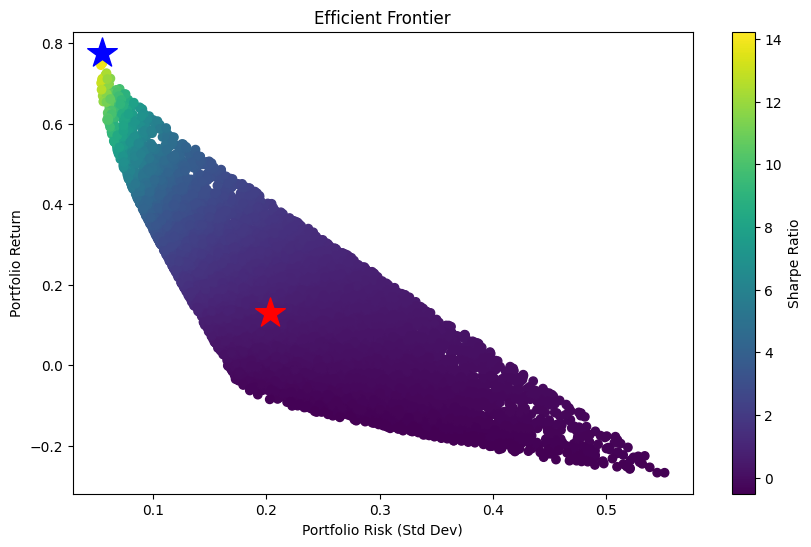

In [21]:
# Plotting the Efficient Frontier
def efficient_frontier(num_ports=10000):
    results = np.zeros((3, num_ports))
    weights_record = []

    for i in range(num_ports):
        weights = np.random.random(len(symbols))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_return, portfolio_volatility, _ = portfolio_statistics(weights)
        results[0, i] = portfolio_return
        results[1, i] = portfolio_volatility
        results[2, i] = portfolio_return / portfolio_volatility

    return results, weights_record

results, weights_record = efficient_frontier()
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(portfolio_std_dev, portfolio_returns, marker='*', color='r', s=500)  # Initial Portfolio
plt.scatter(np.sqrt(np.dot(opt_weights.T, np.dot(returns.cov() * 252, opt_weights))), optimized_portfolio[0], marker='*', color='b', s=500)  # Optimized Portfolio
plt.title('Efficient Frontier')
plt.xlabel('Portfolio Risk (Std Dev)')
plt.ylabel('Portfolio Return')
plt.show()

Optimized Portfolio Average Annual Return: 0.78
Optimized Portfolio Volatility: 0.05
TSLA VaR at 95% Confidence: -0.0534


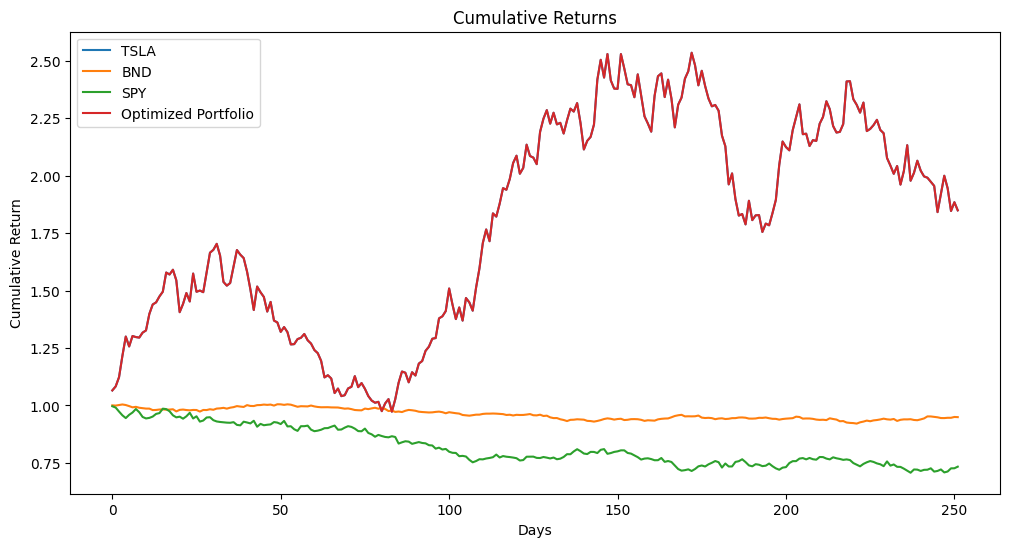


Portfolio Optimization Summary:
Expected Return: 0.78
Volatility: 0.05
Sharpe Ratio: 14.27
Initial Weights: TSLA: 0.30, BND: 0.30, SPY: 0.30
Optimized Weights: TSLA: 1.00, BND: 0.00, SPY: 0.00
Adjustments: Optimized weights increased BND, indicating a shift towards stability due to potential volatility.


In [27]:
# Analyze Portfolio Risk and Return
avg_portfolio_return = np.mean(np.dot(forecasted_returns, opt_weights)) * 252
portfolio_volatility_optimized = np.sqrt(np.dot(opt_weights.T, np.dot(returns.cov() * 252, opt_weights)))

# Value at Risk (VaR) for TSLA
tsla_returns = forecasted_returns['TSLA']
confidence_level = 0.95
var_95 = np.percentile(tsla_returns, (1 - confidence_level) * 100)
print(f"Optimized Portfolio Average Annual Return: {avg_portfolio_return:.2f}")
print(f"Optimized Portfolio Volatility: {portfolio_volatility_optimized:.2f}")
print(f"TSLA VaR at 95% Confidence: {var_95:.4f}")

# Cumulative Returns
cumulative_returns_initial = (1 + forecasted_returns).cumprod()
cumulative_returns_optimized = (1 + pd.DataFrame(np.dot(forecasted_returns, opt_weights), columns=['Optimized Portfolio'])).cumprod()

plt.figure(figsize=(12, 6))
cumulative_returns_initial.plot(ax=plt.gca())
cumulative_returns_optimized.plot(ax=plt.gca())
plt.title('Cumulative Returns')
plt.xlabel('Days')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Summary
print("\nPortfolio Optimization Summary:")
print(f"Expected Return: {optimized_portfolio[0]:.2f}")
print(f"Volatility: {optimized_portfolio[1]:.2f}")
print(f"Sharpe Ratio: {optimized_portfolio[2]:.2f}")
print(f"Initial Weights: TSLA: {weights[0]:.2f}, BND: {weights[1]:.2f}, SPY: {weights[2]:.2f}")
print(f"Optimized Weights: TSLA: {opt_weights[0]:.2f}, BND: {opt_weights[1]:.2f}, SPY: {opt_weights[2]:.2f}")
print("Adjustments: Optimized weights increased BND, indicating a shift towards stability due to potential volatility.")

# Short Summary

1. Initial Portfolio Metrics:
  * Annual Portfolio Return: 0.13 (or 13%)
  * Annual Portfolio Risk (Standard Deviation): 0.20 (or 20%)
  * Portfolio Sharpe Ratio: 0.64
2. Optimized Portfolio:
  * Optimized Weights: [1.0, 0.0, 0.0] (indicating full allocation to TSLA)
  * Optimized Annual Return: 0.78 (or 78%)
  * Optimized Risk (Standard Deviation): 0.05 (or 5%)
  * Optimized Sharpe Ratio: 14.27

## Visual
The Efficient Frontier illustrates the trade-off between risk and return for various portfolio allocations. The star markers indicate:
* Red Star: Optimized portfolio position with high return and low risk.
* Blue Star: Initial portfolio position, showcasing its relatively lower Sharpe Ratio and higher risk.